In [1]:
!python -m pip install pyyaml==5.1 -q
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' -q

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Preparing metadata (setup.py) ... done


In [2]:
import kagglehub
import cv2
from matplotlib import pyplot as plt
!uv pip install ultralytics
from ultralytics import YOLO
import torch

# Импорты
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# Устанавливаем логгер для детектрона
import detectron2
# Для печати логов
from detectron2.utils.logger import setup_logger
# Инициализируем логгер
setup_logger()

# Зоопарк моделей (по аналогии с torchvision.models)
from detectron2 import model_zoo
# Отдельный класс для предикта разными моделями
from detectron2.engine import DefaultPredictor
# Всея конфиг: все будем делать через него
from detectron2.config import get_cfg

# Для визуализации
from detectron2.utils.visualizer import Visualizer

# Для собственного датасета
from detectron2.data import MetadataCatalog, DatasetCatalog

Using Python 3.11.13 environment at: /usr
Audited 1 package in 110ms


In [25]:
path = kagglehub.dataset_download("fareselmenshawii/face-detection-dataset")

In [26]:
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/face-detection-dataset


In [27]:
!ls -lh /kaggle/input/face-detection-dataset/images/train/ff47f45099cadc94.jpg

-rw-r--r-- 1 1000 1000 158K Jul 23 05:08 /kaggle/input/face-detection-dataset/images/train/ff47f45099cadc94.jpg


In [35]:
!mkdir -p /content/face_dataset
!cp -r /kaggle/input/face-detection-dataset/* /content/face_dataset/


In [41]:
!find /content/face_dataset/images/train/ -type f | wc -l


13386


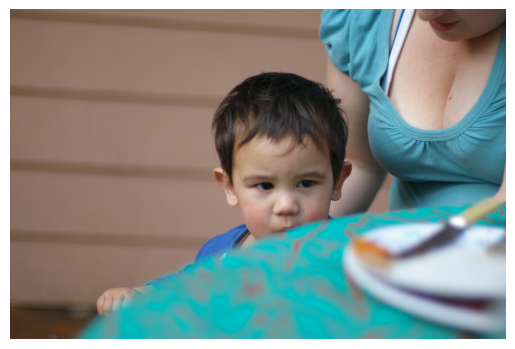

In [36]:
im = cv2.imread("/content/face_dataset/images/train/ff47f45099cadc94.jpg")
plt.imshow(im[:, :, ::-1]) # BlueGreenRed -> RedGreenBlue (=torch.permute)
plt.axis('off');

In [42]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()
torch.cuda.get_device_name()

'Tesla T4'

In [53]:
model = YOLO("/content/runs/detect/train6/weights/best.pt")

In [62]:
results = model.predict("/content/face_dataset/images/val/02d9ec5d9bf105d3.jpg", conf=0.4)


image 1/1 /content/face_dataset/images/val/02d9ec5d9bf105d3.jpg: 288x416 1 face, 56.9ms
Speed: 1.4ms preprocess, 56.9ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 416)


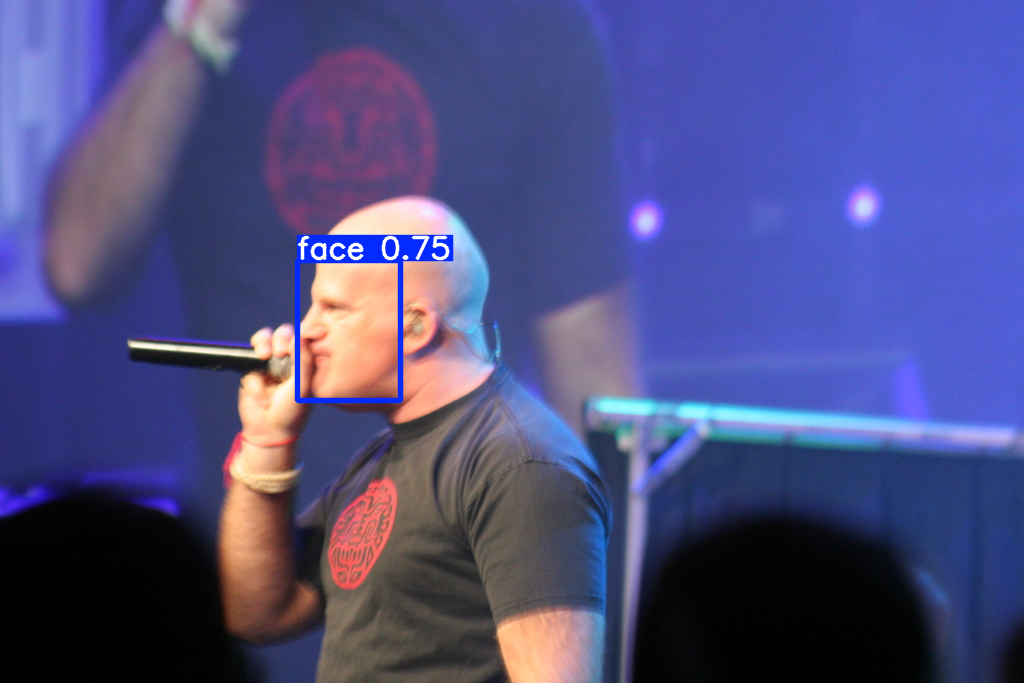

In [63]:
for result in results:
    boxes = result.boxes  # bbox нужен для детекции
    masks = result.masks  # Маска нужна для сегментации
    keypoints = result.keypoints  # Для определения позы
    probs = result.probs  # Для классификации найденного объекта
    obb = result.obb  # Ориентированный bbox
    result.show()  # display to screen

In [47]:
yaml_text = """
  train: /content/face_dataset/images/train
  val: /content/face_dataset/images/val

  nc: 1
  names: ['face']
"""

with open("face.yaml", "w") as f:
    f.write(yaml_text)

In [64]:
results = model.train(
    results = model.train(
    data="/content/face.yaml",
    epochs=5,               # или меньше
    imgsz=416,               # уменьшили размер
    batch=16,
    device=DEVICE,
    optimizer="Adam",
    lr0=0.001,
    workers=2,
    save_period=5,
    cos_lr=True,
    warmup_epochs=0,
    mosaic=0.5,
    hsv_h=0.0,
    hsv_s=0.3,
    hsv_v=0.3,
    erasing=0.0
      )
    )

Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/face.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.0, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.3, hsv_v=0.3, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/runs/detect/train6/weights/best.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=train7, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

train: Scanning /content/face_dataset/labels/train.cache... 13386 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13386/13386 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 876.1±492.9 MB/s, size: 308.9 KB)


val: Scanning /content/face_dataset/labels/val.cache... 3347 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3347/3347 [00:00<?, ?it/s]


Plotting labels to runs/detect/train7/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train7
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.71G      1.247      0.756      1.063         33        416: 100%|██████████| 837/837 [03:53<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:31<00:00,  3.29it/s]

                   all       3347      10299      0.889      0.698      0.787      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.71G      1.233     0.7354      1.058         41        416: 100%|██████████| 837/837 [03:49<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:31<00:00,  3.29it/s]

                   all       3347      10299      0.882      0.709      0.792      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.71G      1.211     0.6989      1.046         32        416: 100%|██████████| 837/837 [03:55<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:33<00:00,  3.16it/s]


                   all       3347      10299      0.894      0.712      0.801      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.71G      1.176     0.6615      1.035         40        416: 100%|██████████| 837/837 [03:48<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:33<00:00,  3.18it/s]


                   all       3347      10299      0.883       0.73      0.811      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.71G      1.159     0.6384      1.026         26        416: 100%|██████████| 837/837 [03:49<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:34<00:00,  3.07it/s]

                   all       3347      10299      0.896      0.734      0.818      0.533



5 epochs completed in 0.368 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 5.5MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,556,923 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [00:36<00:00,  2.85it/s]


                   all       3347      10299      0.896      0.735      0.818      0.533
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train7


SyntaxError: '[31m[1mresults[0m' is not a valid YOLO argument. Similar arguments are i.e. ['resume=False'].

    Arguments received: ['yolo', '-f', '/root/.local/share/jupyter/runtime/kernel-083c9571-5c67-42bb-b8a3-8e7e00d64d1d.json']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of ['obb', 'classify', 'segment', 'pose', 'detect']
                MODE (required) is one of ['train', 'track', 'predict', 'benchmark', 'export', 'val']
                ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
                    See all ARGS at https://docs.ultralytics.com/usage/cfg or with 'yolo cfg'

    1. Train a detection model for 10 epochs with an initial learning_rate of 0.01
        yolo train data=coco8.yaml model=yolo11n.pt epochs=10 lr0=0.01

    2. Predict a YouTube video using a pretrained segmentation model at image size 320:
        yolo predict model=yolo11n-seg.pt source='https://youtu.be/LNwODJXcvt4' imgsz=320

    3. Val a pretrained detection model at batch-size 1 and image size 640:
        yolo val model=yolo11n.pt data=coco8.yaml batch=1 imgsz=640

    4. Export a YOLO11n classification model to ONNX format at image size 224 by 128 (no TASK required)
        yolo export model=yolo11n-cls.pt format=onnx imgsz=224,128

    5. Ultralytics solutions usage
        yolo solutions count or in ['crop', 'blur', 'workout', 'heatmap', 'isegment', 'visioneye', 'speed', 'queue', 'analytics', 'inference', 'trackzone'] source="path/to/video.mp4"

    6. Run special commands:
        yolo help
        yolo checks
        yolo version
        yolo settings
        yolo copy-cfg
        yolo cfg
        yolo solutions help

    Docs: https://docs.ultralytics.com
    Solutions: https://docs.ultralytics.com/solutions/
    Community: https://community.ultralytics.com
    GitHub: https://github.com/ultralytics/ultralytics
     (<string>)

In [65]:
# Модель до дообучения
model6 = YOLO("/content/runs/detect/train6/weights/best.pt")
results6 = model6.val()

# Модель после дообучения
model7 = YOLO("/content/runs/detect/train7/weights/best.pt")
results7 = model7.val()

print("Train6 mAP50:", results6.box.map50)
print("Train7 mAP50:", results7.box.map50)


Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,556,923 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1978.2±229.8 MB/s, size: 134.1 KB)


val: Scanning /content/face_dataset/labels/val.cache... 3347 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3347/3347 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 210/210 [00:38<00:00,  5.44it/s]


                   all       3347      10299       0.89      0.735      0.817      0.532
Speed: 0.1ms preprocess, 3.9ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,556,923 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2108.4±918.9 MB/s, size: 232.3 KB)


val: Scanning /content/face_dataset/labels/val.cache... 3347 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3347/3347 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 210/210 [00:35<00:00,  5.90it/s]


                   all       3347      10299      0.896      0.734      0.818      0.533
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val2
Train6 mAP50: 0.817075272523149
Train7 mAP50: 0.8182617859912694


In [71]:
results = model6.predict("https://st.depositphotos.com/1017986/4661/i/450/depositphotos_46613105-stock-photo-group-of-friends-having-fun.jpg", conf=0.4)


WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP came

  0%|          | 0.00/35.5k [00:00<?, ?B/s]

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.


100%|██████████| 35.5k/35.5k [00:00<00:00, 14.4MB/s]

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
image 1/1 /content/depositphotos_46613105-stock-photo-group-of-friends-having-fun.jpg: 288x416 7 faces, 19.9ms
Speed: 1.8ms preprocess, 19.9ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 416)


WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.


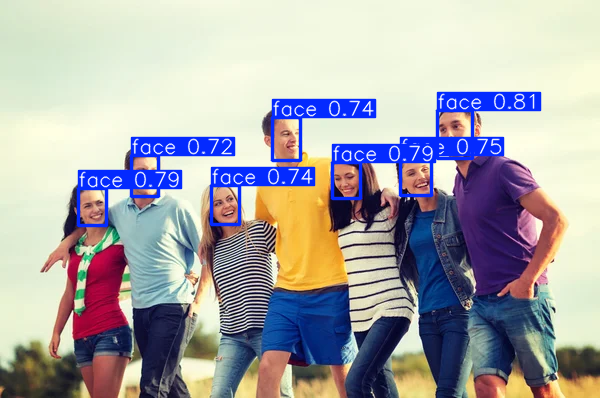

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.


In [72]:
for result in results:
    boxes = result.boxes  # bbox нужен для детекции
    masks = result.masks  # Маска нужна для сегментации
    keypoints = result.keypoints  # Для определения позы
    probs = result.probs  # Для классификации найденного объекта
    obb = result.obb  # Ориентированный bbox
    result.show()  # display to screen

In [73]:
results = model7.predict("https://st.depositphotos.com/1017986/4661/i/450/depositphotos_46613105-stock-photo-group-of-friends-having-fun.jpg", conf=0.4)


Found https://st.depositphotos.com/1017986/4661/i/450/depositphotos_46613105-stock-photo-group-of-friends-having-fun.jpg locally at depositphotos_46613105-stock-photo-group-of-friends-having-fun.jpg
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
image 1/1 /content/depositphotos_46613105-stock-photo-group-of-friends-having-fun.jpg: 288x416 7 faces, 28.3ms
Speed: 1.7ms preprocess, 28.3ms inference, 2.2ms postprocess per image at shape (1, 3, 288, 416)
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.


WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.


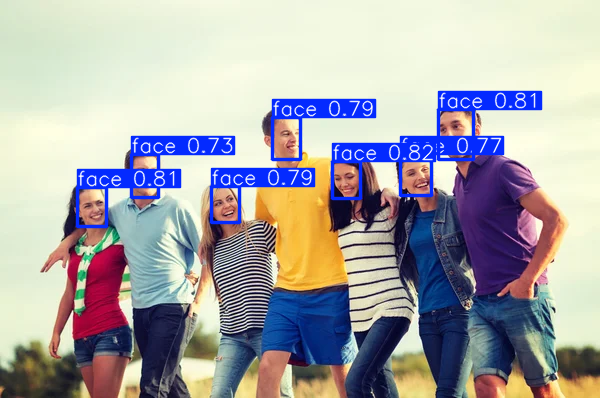

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.


In [74]:
for result in results:
    boxes = result.boxes  # bbox нужен для детекции
    masks = result.masks  # Маска нужна для сегментации
    keypoints = result.keypoints  # Для определения позы
    probs = result.probs  # Для классификации найденного объекта
    obb = result.obb  # Ориентированный bbox
    result.show()  # display to screen

In [97]:
# Загрузка модели и изображения
!wget https://img.freepik.com/free-photo/group-friends-party_23-2148115665.jpg -q -O input.jpg
image = cv2.imread("./input.jpg")


# Получаем предсказания
results = model7(image)[0]

# Копия изображения
blurred_img = image.copy()

# Проходимся по каждому боксу
for box in results.boxes.xyxy.cpu().numpy():
    x1, y1, x2, y2 = box.astype(int)

    # Вырезаем лицо
    face_roi = blurred_img[y1:y2, x1:x2]

    # Блюрим лицо
    face_blur = cv2.GaussianBlur(face_roi, (35, 35), 30)

    # Вставляем обратно
    blurred_img[y1:y2, x1:x2] = face_blur

# Сохраняем результат
cv2.imwrite("faces_blurred.jpg", blurred_img)


WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camer

True

In [98]:
original = cv2.imread("/content/input.jpg")
blurred = cv2.imread("/content/faces_blurred.jpg")

combined = np.hstack((original, blurred))
cv2.imwrite("combined_faces.jpg", combined)

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.


True

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.


WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.


(np.float64(-0.5), np.float64(1251.5), np.float64(417.5), np.float64(-0.5))

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camer

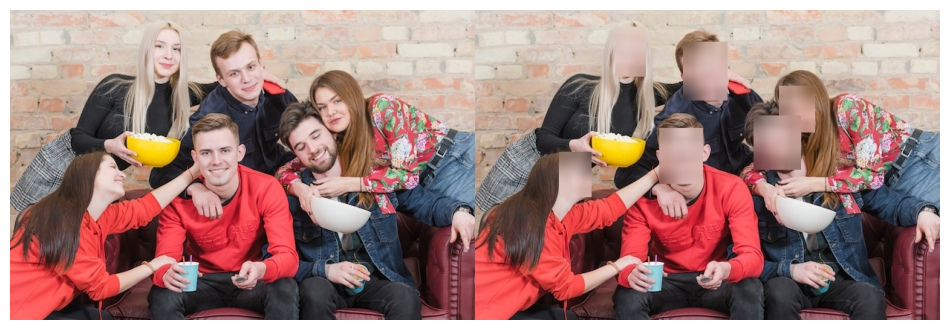

In [99]:
final_image = cv2.imread('/content/combined_faces.jpg')

plt.figure(figsize=(12,6))
plt.imshow(final_image[:, :, ::-1])
plt.axis('off')